In [220]:
import pandas as pd
import re

In [221]:
train = pd.read_csv("data/Corona_NLP_train.csv", encoding='ISO-8859-1')
test = pd.read_csv("data/Corona_NLP_test.csv", encoding='ISO-8859-1')

In [222]:
df = pd.concat([test, train], ignore_index=True)

In [223]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format="%d-%m-%Y")


In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       44955 non-null  int64         
 1   ScreenName     44955 non-null  int64         
 2   Location       35531 non-null  object        
 3   TweetAt        44955 non-null  datetime64[ns]
 4   OriginalTweet  44955 non-null  object        
 5   Sentiment      44955 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.1+ MB


In [225]:
df = df.sort_values(by='TweetAt').reset_index(drop=True)

In [226]:
df = df[["TweetAt", "OriginalTweet", "Sentiment"]]

In [227]:
print(str(df["TweetAt"].min()) + "  <-- min date")
print(str(df["TweetAt"].max()) + "  <-- max date")

2020-03-02 00:00:00  <-- min date
2020-04-14 00:00:00  <-- max date


In [228]:
text = df[["TweetAt", "OriginalTweet"]]

In [229]:
text["length"] = text["OriginalTweet"].apply(lambda x: len(x))

In [230]:
mentions = text['OriginalTweet'].str.findall(r'(@\w+)')

In [231]:
text.insert(3,'nbr_mentions', mentions.apply(lambda x : len(x)))

In [232]:
mentions = mentions.explode().value_counts(True)
mentions

@realDonaldTrump    0.014899
@Tesco              0.010376
@sainsburys         0.009418
@BorisJohnson       0.008141
@amazon             0.006385
                      ...   
@Billtony91         0.000053
@BBCEngland         0.000053
@parademag          0.000053
@JohnFMauldin       0.000053
@TartiiCat          0.000053
Name: OriginalTweet, Length: 11163, dtype: float64

In [233]:
def remove_usernames_links(df):
    df = re.sub('#[^\s]+', '', df)
    df = re.sub('@[^\s]+','',df)
    df = re.sub('http[^\s]+','',df) 
    df = re.sub(' +', ' ', df)
    return df

In [234]:
df["text_without_tags"] = df["OriginalTweet"].apply(remove_usernames_links)

In [235]:
df

,TweetAt,OriginalTweet,Sentiment,text_without_tags
0,2020-03-02,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,TRENDING: New Yorkers encounter empty supermar...
1,2020-03-02,When I couldn't find hand sanitizer at Fred Me...,Positive,When I couldn't find hand sanitizer at Fred Me...
2,2020-03-02,Find out how you can protect yourself and love...,Extremely Positive,Find out how you can protect yourself and love...
3,2020-03-02,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits City as anxious shoppers stock up...
4,2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,One week everyone buying baby milk powder the...
...,...,...,...,...
44950,2020-04-14,Breweries are making hand sanitizer over booze...,Positive,Breweries are making hand sanitizer over booze...
44951,2020-04-14,Just scolded my dad who wanted to go supermark...,Extremely Negative,Just scolded my dad who wanted to go supermark...
44952,2020-04-14,COVID-19 Special LIVE Phone-In Program with Sh...,Positive,COVID-19 Special LIVE Phone-In Program with Sh...
44953,2020-04-14,"We may be saying goodbye to paper flyers soon,...",Positive,"We may be saying goodbye to paper flyers soon,..."


In [236]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [237]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rogermauvois/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rogermauvois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [238]:
def remove_stopwords(text):
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.lower() not in stop_words]
    return " ".join(words_filtered)

In [239]:
df['text_without_tags'] = df['text_without_tags'].apply(lambda x: remove_stopwords(x.lower()))

In [240]:
df["text_without_tags"].iloc[0]

'trending : new yorkers encounter empty supermarket shelves ( pictured , wegmans brooklyn ) , sold-out online grocers ( foodkick , maxdelivery ) shoppers stock'

### Modèle

In [241]:
sentiment_mapping = {
    'Extremely Negative': -1,
    'Negative': -0.5,
    'Neutral': 0,
    'Positive': 0.5,
    'Extremely Positive': 1
}

In [242]:
df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

In [243]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, TextVectorization
from tensorflow.keras import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant



In [244]:
from sklearn.model_selection import train_test_split

In [245]:
X = df["text_without_tags"].values
y = df["Sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [246]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

In [247]:
X_train.shape, X_val.shape, X_test.shape

((26747,), (11464,), (6744,))

In [302]:
embedding_dim = 50
max_tokens = 20000
embedding_matrix = np.zeros((max_tokens, embedding_dim))

In [304]:
def custom_tanh(x):
    return K.tanh(x /7)

In [305]:
model = Sequential()

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=50,
                                    output_mode='int',
                                    name="text_vectorizer")
text_vectorizer.adapt(X_train)

model.add(text_vectorizer)


model.add(Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix)
    # trainable=False, 
    # mask_zero=True
    )
)
model.add(LSTM(100))
model.add(Dense(1, activation=custom_tanh))

model.compile(optimizer="Adam", loss= "mean_squared_error")

sample_text_data = ['trending : new yorkers encounter empty supermarket shelves ( pictured , wegmans brooklyn ) , sold-out online grocers ( foodkick , maxdelivery ) shoppers stock']
model.predict(sample_text_data)

model.summary()

1/1 [==============================] - 1s 614ms/step
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorizer (TextVecto  (None, 50)                0         
 rization)                                                       
                                                                 
 embedding_25 (Embedding)    (None, 50, 50)            1000000   
                                                                 
 lstm_25 (LSTM)              (None, 100)               60400     
                                                                 
 dense_25 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1060501 (4.05 MB)
Trainable params: 1060501 (4.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [298]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [306]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, start_from_epoch=20 ),
    ModelCheckpoint(filepath='best_model.tf', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # You can adjust the number of epoch
    callbacks=callbacks
)

Epoch 1/200
835/836 [============================>.] - ETA: 0s - loss: 0.4276INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 38s 42ms/step - loss: 0.4276 - val_loss: 0.4184
Epoch 2/200
836/836 [==============================] - ETA: 0s - loss: 0.4280INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 34s 41ms/step - loss: 0.4280 - val_loss: 0.4181
Epoch 3/200
835/836 [============================>.] - ETA: 0s - loss: 0.4280INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 35s 41ms/step - loss: 0.4280 - val_loss: 0.4181
Epoch 4/200
835/836 [============================>.] - ETA: 0s - loss: 0.4279INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 34s 40ms/step - loss: 0.4279 - val_loss: 0.4180
Epoch 5/200
836/836 [==============================] - ETA: 0s - loss: 0.4222INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 32s 39ms/step - loss: 0.4222 - val_loss: 0.3935
Epoch 6/200
835/836 [============================>.] - ETA: 0s - loss: 0.3946INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 33s 40ms/step - loss: 0.3946 - val_loss: 0.3911
Epoch 7/200
836/836 [==============================] - 27s 33ms/step - loss: 0.3869 - val_loss: 0.3924
Epoch 8/200
836/836 [==============================] - 29s 35ms/step - loss: 0.3896 - val_loss: 0.4024
Epoch 9/200
836/836 [==============================] - 28s 33ms/step - loss: 0.3916 - val_loss: 0.3997
Epoch 10/200
836/836 [==============================] - 27s 33ms/step - loss: 0.3882 - val_loss: 0.3971
Epoch 11/200
836/836 [==============================] - 28s 33ms/step - loss: 0.3858 - val_loss: 0.3965
Epoch 12/200
836/836 [==============================] - 27s 33ms/step - loss: 0.3858 - val_loss: 0.3947
Epoch 13/200
836/836 [==============================] - 31s 37ms/step - loss: 0.3824 - val_loss: 0.3954
Epoch 14/200
836/836 [==============================] - 33s 39ms/step - loss: 0.3831 - val_loss: 0.3961
Epoch 15/200
836/836 [==============================] - 28s 34ms/step - loss: 0.

INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 35s 42ms/step - loss: 0.3781 - val_loss: 0.3888
Epoch 20/200
835/836 [============================>.] - ETA: 0s - loss: 0.3119INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 33s 39ms/step - loss: 0.3118 - val_loss: 0.2070
Epoch 21/200
836/836 [==============================] - ETA: 0s - loss: 0.1732INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 35s 42ms/step - loss: 0.1732 - val_loss: 0.1527
Epoch 22/200
835/836 [============================>.] - ETA: 0s - loss: 0.0981INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 31s 38ms/step - loss: 0.0981 - val_loss: 0.1317
Epoch 23/200
836/836 [==============================] - ETA: 0s - loss: 0.0781INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 34s 40ms/step - loss: 0.0781 - val_loss: 0.1278
Epoch 24/200
836/836 [==============================] - ETA: 0s - loss: 0.0522INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 33s 39ms/step - loss: 0.0522 - val_loss: 0.1269
Epoch 25/200
836/836 [==============================] - 27s 32ms/step - loss: 0.0412 - val_loss: 0.1279
Epoch 26/200
836/836 [==============================] - ETA: 0s - loss: 0.0334INFO:tensorflow:Assets written to: best_model.tf/assets


INFO:tensorflow:Assets written to: best_model.tf/assets


836/836 [==============================] - 32s 39ms/step - loss: 0.0334 - val_loss: 0.1246
Epoch 27/200
836/836 [==============================] - 27s 33ms/step - loss: 0.0292 - val_loss: 0.1299
Epoch 28/200
836/836 [==============================] - 28s 33ms/step - loss: 0.0267 - val_loss: 0.1264
Epoch 29/200
836/836 [==============================] - 28s 34ms/step - loss: 0.0224 - val_loss: 0.1353
Epoch 30/200
836/836 [==============================] - 28s 33ms/step - loss: 0.0197 - val_loss: 0.1357
Epoch 31/200
836/836 [==============================] - 28s 34ms/step - loss: 0.0176 - val_loss: 0.1327
Epoch 32/200
836/836 [==============================] - 28s 33ms/step - loss: 0.0162 - val_loss: 0.1331


211/211 [==============================] - 2s 9ms/step - loss: 0.1366


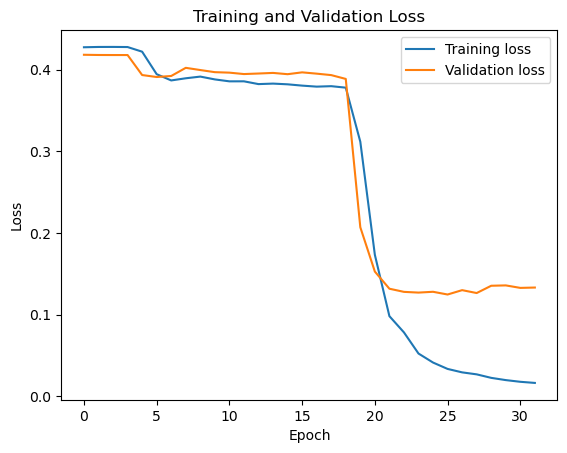

In [307]:
test_loss = model.evaluate(X_test, y_test)

# Optionally, you can plot the training history for analysis
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [311]:
prediction = model.predict(X_test)

211/211 [==============================] - 2s 9ms/step


In [314]:
prediction[:,0]

array([-0.19158962,  0.96405005, -0.07637209, ...,  0.9512711 ,
       -0.49431255,  0.482968  ], dtype=float32)

In [317]:
np.around(prediction[:,0]/0.25)/4

array([-0.25,  1.  , -0.  , ...,  1.  , -0.5 ,  0.5 ], dtype=float32)

In [319]:
from sklearn.metrics import classification_report

In [334]:
y_pred = ((np.around(prediction[:,0] * 2))/2)


array([-0. ,  1. , -0. , ...,  1. , -0.5,  0.5], dtype=float32)

In [340]:
y_pred = (y_pred +1) * 2

In [341]:
y_pred

array([2., 4., 2., ..., 4., 1., 3.], dtype=float32)

In [332]:
np.around(prediction[:,0]/0.5)

array([-0.,  2., -0., ...,  2., -1.,  1.], dtype=float32)

In [337]:
y_test = y_test-2

In [338]:
y_test

array([3., 4., 3., ..., 4., 0., 3.])

In [345]:
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

In [360]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71       894
         1.0       0.62      0.58      0.60      1609
         2.0       0.65      0.74      0.69      1289
         3.0       0.68      0.70      0.69      1887
         4.0       0.79      0.75      0.77      1065

    accuracy                           0.69      6744
   macro avg       0.70      0.69      0.69      6744
weighted avg       0.69      0.69      0.68      6744



In [346]:
report

,0.0,1.0,2.0,3.0,4.0,accuracy,macro avg,weighted avg
precision,0.732861,0.623749,0.651131,0.682573,0.790514,0.685202,0.696165,0.686241
recall,0.693512,0.581106,0.737005,0.697403,0.751174,0.685202,0.692040,0.685202
f1-score,0.712644,0.601673,0.691412,0.689908,0.770342,0.685202,0.693196,0.684860
support,894.000000,1609.000000,1289.000000,1887.000000,1065.000000,0.685202,6744.000000,6744.000000


In [349]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [348]:
confusion_matrix(y_test, y_pred)

array([[ 620,  224,   24,   24,    2],
       [ 196,  935,  270,  187,   21],
       [   5,  167,  950,  164,    3],
       [  23,  159,  203, 1316,  186],
       [   2,   14,   12,  237,  800]])

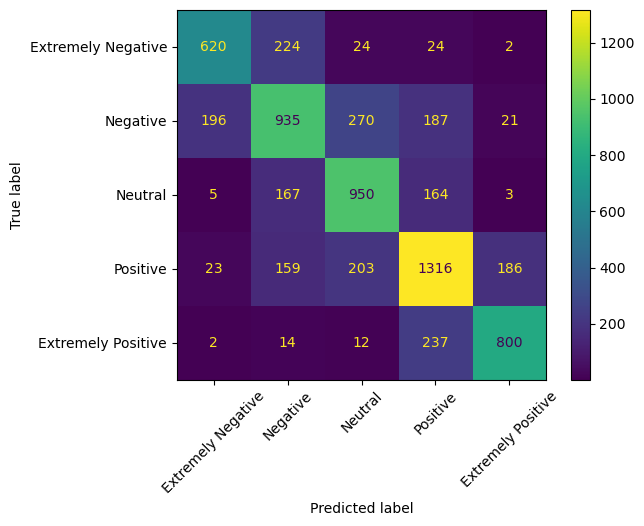

In [364]:
cm = confusion_matrix(y_test, y_pred)

# Create the ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(sentiment_mapping.keys()))

# Plot the confusion matrix
ax = disp.plot().ax_

# Set the background color; RGB values are scaled to [0, 1]
ax.set_facecolor((100/255, 100/255, 100/255))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [354]:
sentiment_mapping.keys()

dict_keys(['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])

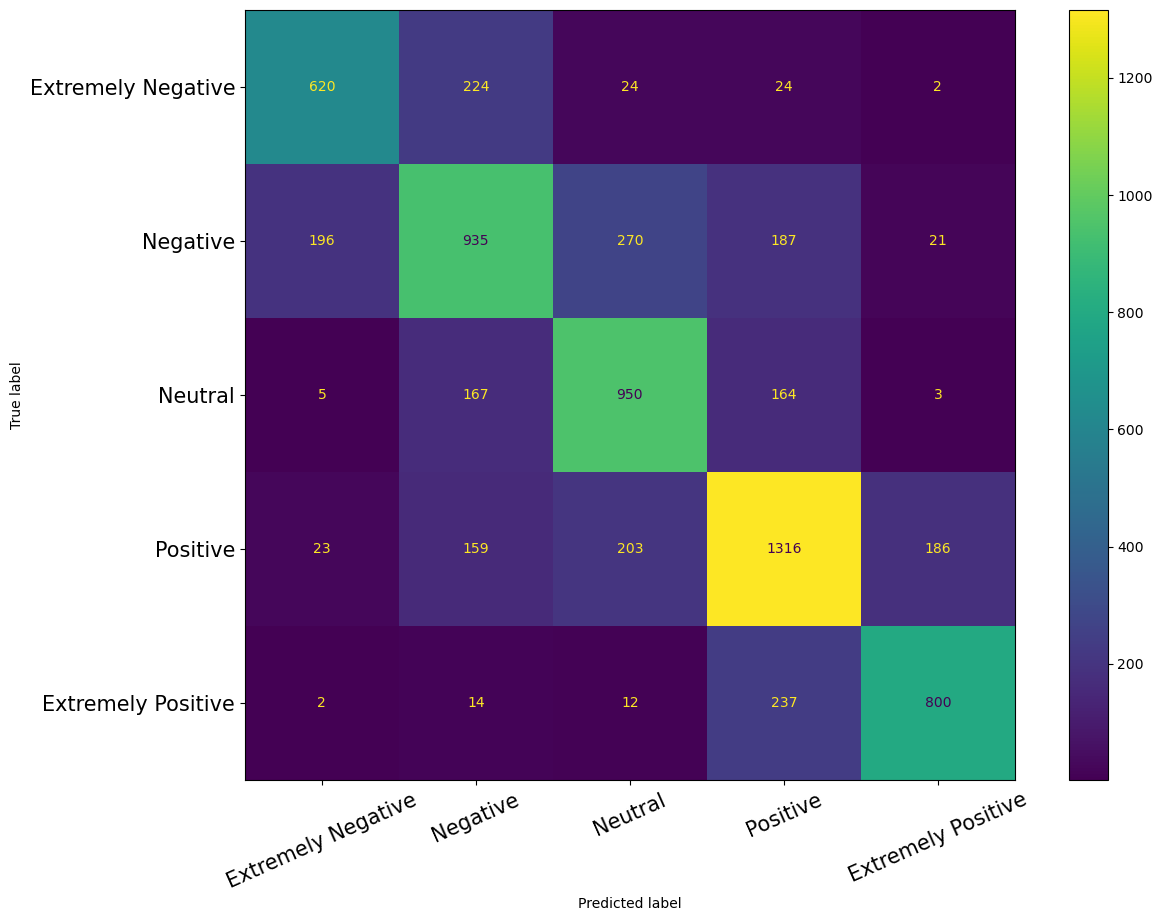

In [380]:
_,ax = plt.subplots(figsize=(14, 10))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=list(sentiment_mapping.keys())).plot(ax=ax)
plt.xticks(rotation=24, fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig("confusion_matrix.svg")

In [381]:
X_train

array(["something tells 'free ' 'need ' attracted many cars . notice hooptie among . another feed panic story .",
       '6.6 oz 80 % alcohol hand sanitizer . high alcohol content kills & amp ; neutralizes covid-19 compared thicker gel-type sanitizers sold . grab business , sales',
       'ministry trade industry reiterated call cautioning retailers wholesalers taking advantage novel outbreak increase prices products . full story ? ?',
       ..., "blue supermarket queue 's stressful ...",
       'outbreak triggered profiteering essential items sold black market government price ceiling solved issue , said consumer group',
       'tried buy masks back mid february . ebay amazon already left sky high prices . government lied . wearing masks beginning .'],
      dtype=object)